## Stochastic SIR with rewiring

In [1]:
from SIR_adaptive import *
from SEIRD_fear import *



## SIR Adaptive

### Choose the network

Average degree:  3.973333333333333


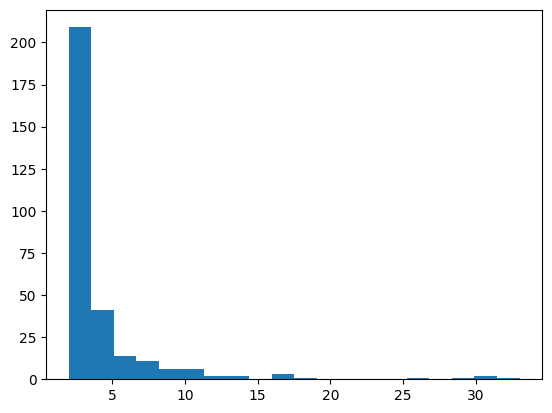

In [10]:

#BA=nx.watts_strogatz_graph(1000,5, 0.5, seed=42) 
BA=nx.barabasi_albert_graph(300, 2)
#BA = nx.configuration_model(nx.random_powerlaw_tree_sequence(500,gamma=2.8 ,tries=100000)); BA.remove_edges_from(nx.selfloop_edges(BA))
#BA=nx.connected_watts_strogatz_graph(1000,8, 0.5, tries=100000)
#BA = nx.read_edgelist("facebook_combined.txt", create_using=nx.Graph(), nodetype=int)

#print degree distribution
degree_sequence = sorted([d for n, d in BA.degree()], reverse=True)  # degree sequence
average_degree = sum(degree_sequence)/len(degree_sequence)
print("Average degree: ", average_degree)
plt.hist(degree_sequence, bins=20)

plt.show()

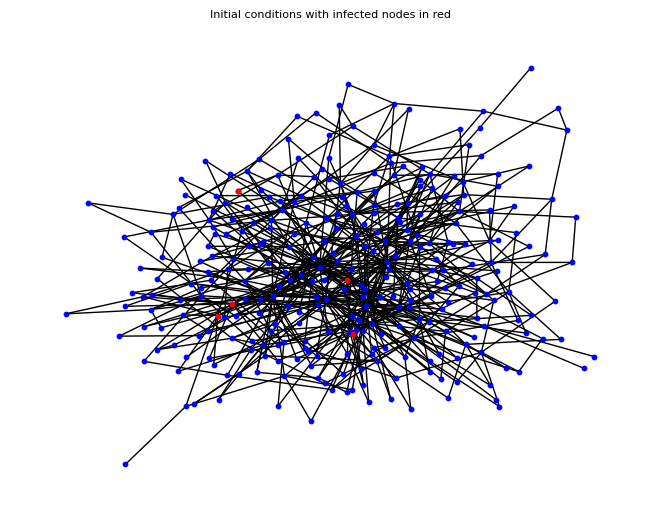

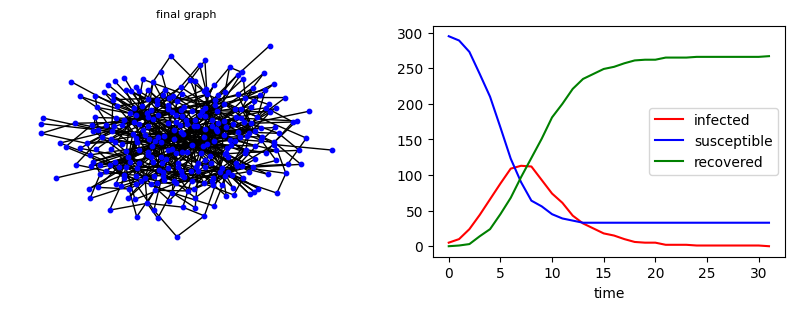

In [13]:



S,I,R=[],[],[]


G_start,S_start,I_start,R_start=initialize_SIR(BA,I0=5,visualize=True)


S.append(S_start[0]) 
I.append(I_start[0])
R.append(R_start[0])


G_start,t,S,I,R = SIR_adaptive(G_start,S,I,R, beta=0.3, mu=0.3,adaptive=True,simulation_time=1000,theta=0.1,info=False)

plot_sim(G_start,S,I,R)


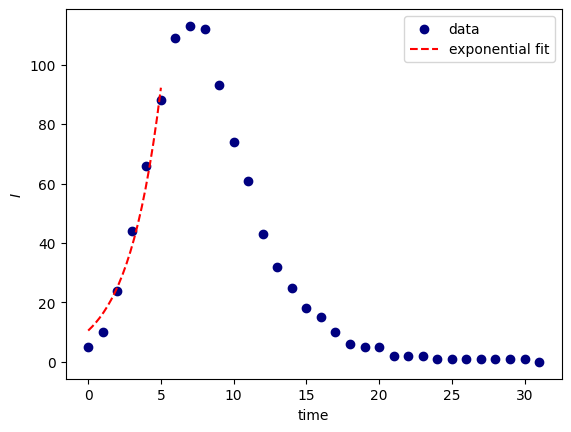

G = 0.4338583921633122

R0 = 5.338583921633122


In [14]:
R0 = fitR0(I, start = 0, mu = 0.1, log = False, info=True)

average degree: 4.0
converged in: 73 steps
maximal number of infected nodes: 224 at time step: 17


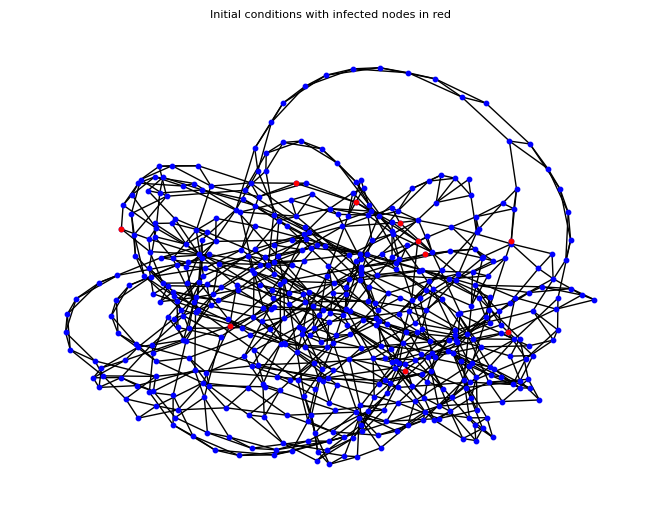

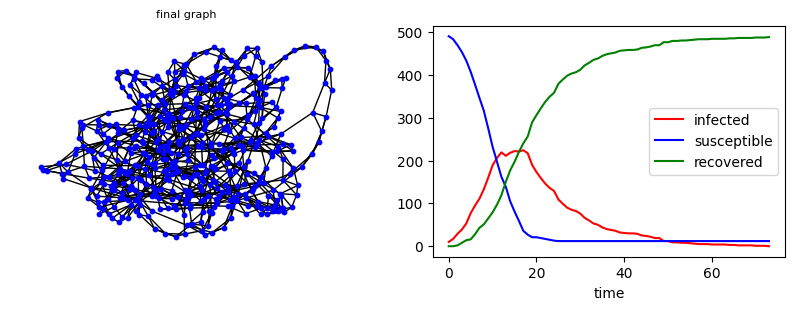

converged in: 61 steps
maximal number of infected nodes: 309 at time step: 12


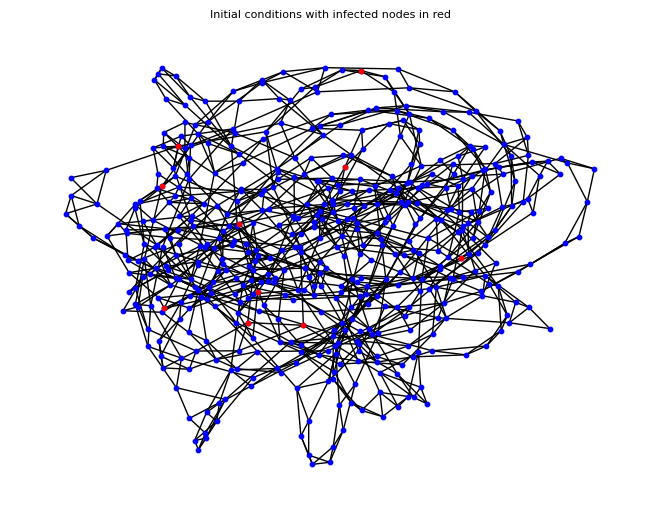

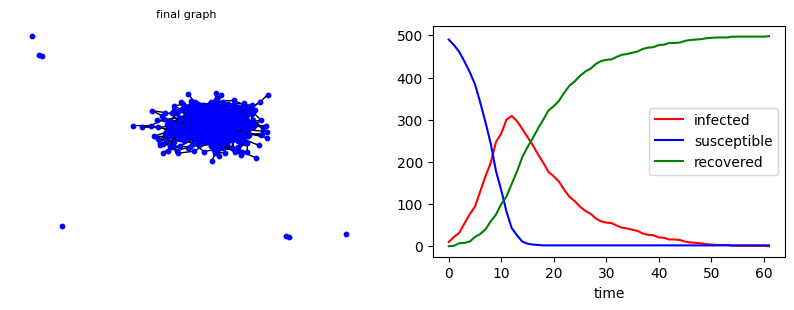

average degree: 4.0


In [16]:
#Choose the graph

#G= nx.barabasi_albert_graph(500, 2)
G=nx.watts_strogatz_graph(500,5, 0.15, seed=42) 
#G= nx.erdos_renyi_graph(100, 0.1)
#G=nx.watts_strogatz_graph(100, 6, 0.5, seed=42)
#G=nx.connected_watts_strogatz_graph(100, 6, 0.5, seed=42)
#G = nx.configuration_model(nx.random_powerlaw_tree_sequence(1000,gamma=2.8 ,tries=100000)); G.remove_edges_from(nx.selfloop_edges(G))

#calculate average degree
k = np.mean([d for n, d in G.degree()])
print("average degree:", k)
stat,dyn,I,I_dyn,t_stat,t_dyn=compare(G, I0=10, beta=0.3, mu=0.1,theta=0.9,sim_time=1000,info=True)
#final degree
k = np.mean([d for n, d in dyn.degree()])
print("average degree:", k)

100%|██████████| 25/25 [02:39<00:00,  6.39s/it]


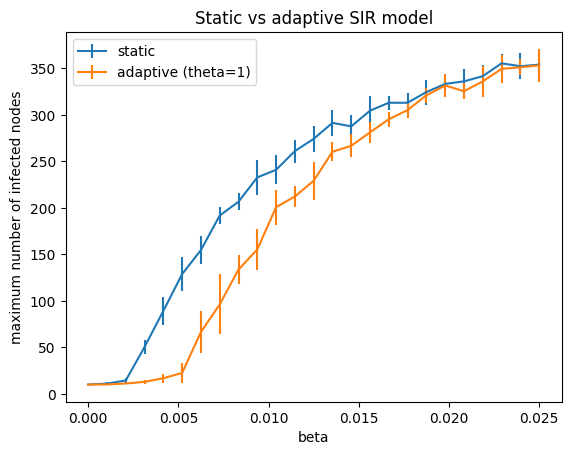

In [23]:
# perform a simulation for the static and adaptive case varying only the rewiring threshold
# and plot the number of infected nodes over time for both cases
#BA=nx.watts_strogatz_graph(500,5, 0.15, seed=42) 
#BA= nx.barabasi_albert_graph(500, 2)
#BA = nx.erdos_renyi_graph(500, 0.1)
BA=nx.watts_strogatz_graph(500,5, 0.15, seed=42) 
betas = np.linspace(0, 0.025, 25)
I_stat = []
I_dyn = []
std_stat = []
std_dyn = []

n_sim = 10

for b in tqdm(betas):
    Istat = []
    Idyn = []
    for i in range(n_sim):
        BA = nx.erdos_renyi_graph(500, 0.1)
        _, _, I_stat_, I_dyn_, _, _ = compare(BA, I0=10, beta=b, mu=0.1, theta=1, sim_time=1000, info=False)
        Istat.append(max(I_stat_))
        Idyn.append(max(I_dyn_))

    I_stat.append(np.mean(Istat))
    I_dyn.append(np.mean(Idyn))
    std_stat.append(np.std(Istat))
    std_dyn.append(np.std(Idyn))

plt.errorbar(betas, I_stat, yerr=std_stat, label='static')
plt.errorbar(betas, I_dyn, yerr=std_dyn, label='adaptive (theta=1)')
plt.xlabel('beta')
plt.ylabel('maximum number of infected nodes')
plt.title('Static vs adaptive SIR model')
plt.legend()
plt.savefig('img/static_vs_adaptive.png', dpi=300)
plt.show()

### Simulation varying beta and theta

In [122]:
BA=nx.watts_strogatz_graph(500,5, 0.15, seed=42) 
#BA=nx.barabasi_albert_graph(500, 2)
#print average degree
k = np.mean([d for n, d in BA.degree()])
print("average degree:", k)
mu=0.3
beta=np.linspace(0.1,0.9,9)
theta=np.linspace(0.1,0.9,9)

R0_stat = np.zeros((len(beta),len(theta)))
R0_adaptive = np.zeros((len(beta),len(theta)))
I_max = np.zeros((len(beta),len(theta)))            #maximal number of infected nodes
I_max_adaptive = np.zeros((len(beta),len(theta)))
t_max_stat = np.zeros((len(beta),len(theta)))       #time of extinction of the epidemic
t_max_adaptive = np.zeros((len(beta),len(theta)))

num_simulations = 10

for i in tqdm(range(len(beta))):
    for j in range(len(theta)):
        R0_stat_sum = 0
        R0_adaptive_sum = 0
        I_max_sum = 0
        I_max_adaptive_sum = 0
        t_stat_sum = 0
        t_adaptive_sum = 0
        
        for _ in range(num_simulations):
            stat,dyn,I,I_dyn,t_stat,t_dyn=compare(BA, I0=10, beta=beta[i], mu=mu,theta=theta[j],sim_time=1000,info=False)
            R0_stat_sum += fitR0(I, start = 0, mu = mu, log = False, info=False)
            R0_adaptive_sum += fitR0(I_dyn, start = 0, mu = mu, log = False, info=False)
            I_max_sum += max(I)
            I_max_adaptive_sum += max(I_dyn)
            t_stat_sum += t_stat
            t_adaptive_sum += t_dyn
        
        R0_stat[i,j] = R0_stat_sum / num_simulations
        R0_adaptive[i,j] = R0_adaptive_sum / num_simulations
        I_max[i,j] = I_max_sum / num_simulations
        I_max_adaptive[i,j] = I_max_adaptive_sum / num_simulations
        t_max_stat[i,j] = t_stat_sum / num_simulations
        t_max_adaptive[i,j] = t_adaptive_sum / num_simulations

#save the results to a dataframe for easier visualization
R0_stat = pd.DataFrame(R0_stat, index=np.round(beta,2), columns=np.round(theta,2))
R0_adaptive = pd.DataFrame(R0_adaptive, index=np.round(beta,2), columns=np.round(theta,2))
I_max = pd.DataFrame(I_max, index=np.round(beta,2), columns=np.round(theta,2)) #final attack rate
I_max_adaptive = pd.DataFrame(I_max_adaptive, index=np.round(beta,2), columns=np.round(theta,2))
t_stat = pd.DataFrame(t_max_stat, index=np.round(beta,2), columns=np.round(theta,2)) #time to extinction
t_adaptive = pd.DataFrame(t_max_adaptive, index=np.round(beta,2), columns=np.round(theta,2))


average degree: 4.0


  0%|          | 0/9 [00:00<?, ?it/s]/Users/roben/miniconda3/envs/torch-gpu/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 9/9 [00:41<00:00,  4.60s/it]


### plot R0

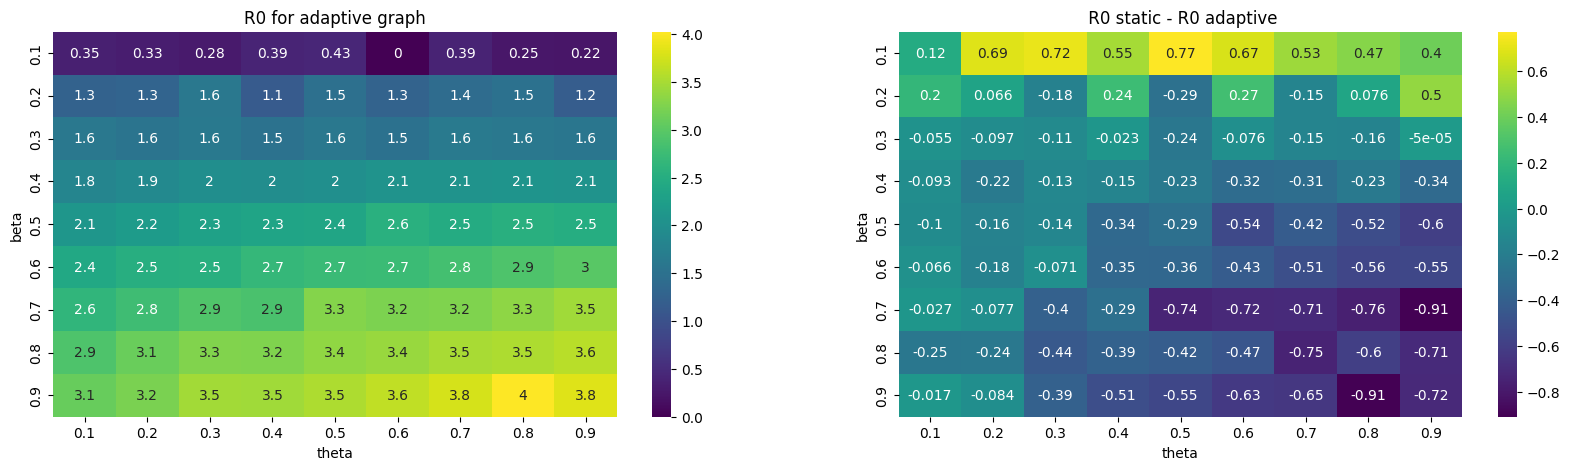

In [124]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(R0_adaptive, annot=True, cmap='viridis')
plt.title('R0 for adaptive graph')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)

sns.heatmap(R0_stat-R0_adaptive, annot=True, cmap='viridis')
plt.title(' R0 static - R0 adaptive')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/R0_SIR_adaptive.png', dpi=300)
plt.show()


### Final attack rate

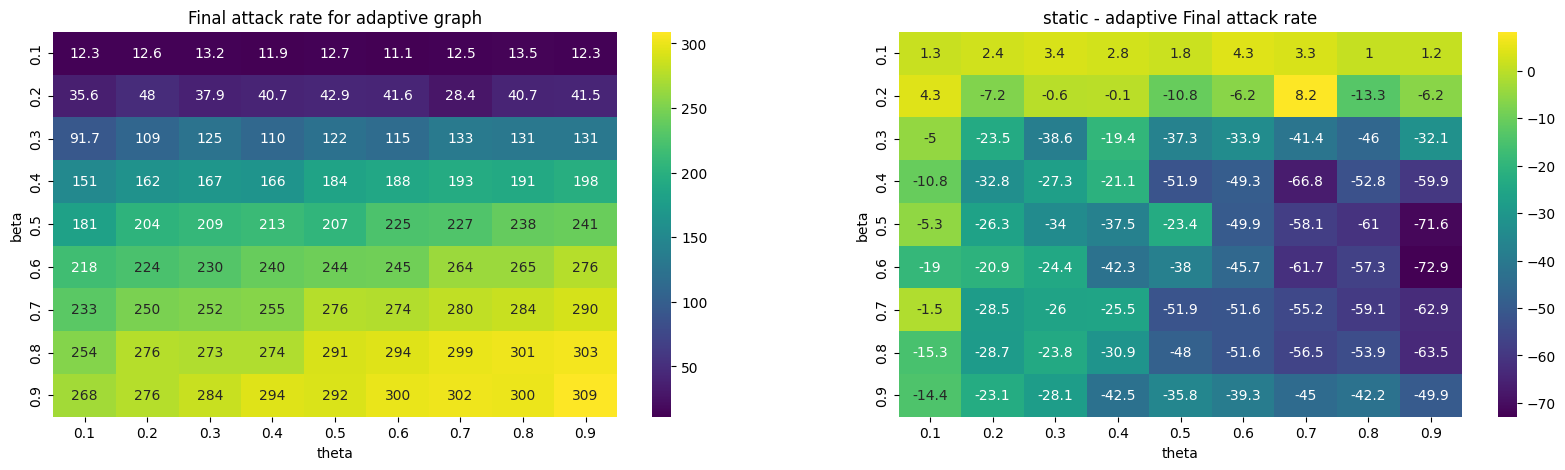

In [125]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(I_max_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('Final attack rate for adaptive graph')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)
sns.heatmap(I_max-I_max_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('static - adaptive Final attack rate')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/attack_rate_SIR_adaptive.png', dpi=300)
plt.show()


### plot time to converge 

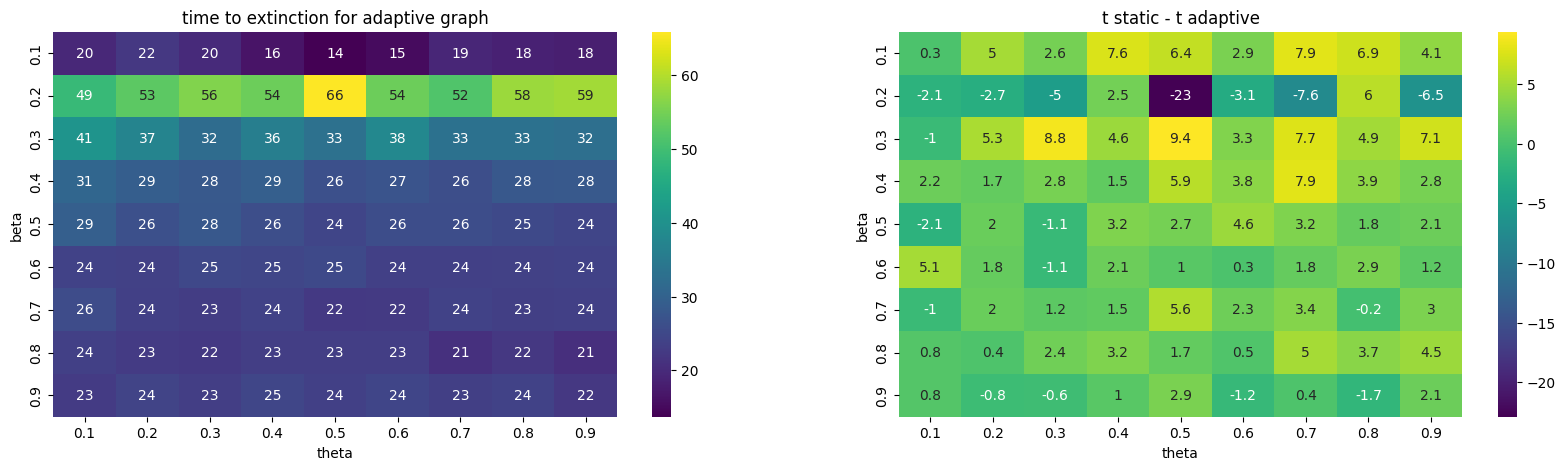

In [126]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(t_adaptive, annot=True, cmap='viridis')
plt.title('time to extinction for adaptive graph')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)

sns.heatmap(t_stat-t_adaptive, annot=True, cmap='viridis')
plt.title('t static - t adaptive')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/time_to_extinction_SIR_adaptive.png', dpi=300)
plt.show()


### conclusion on the adaptive model
* for very low values of beta (<0.02) the adaptive case has a lower final attack rate, hence the rewiring helps to slow down the epidemic
*  instead for higher value of beta the rewiring facilitate the epidemic because this dynamic creates hubs on which the epidemic can spread quickly.
* This is clear from the heatmap: R0 and final attack rate higher for the adaptive case and so the extinction time is lower than the static case.

## SEIRD model

converged in: 56 steps
maximal number of infected nodes: 273 at time step: 20


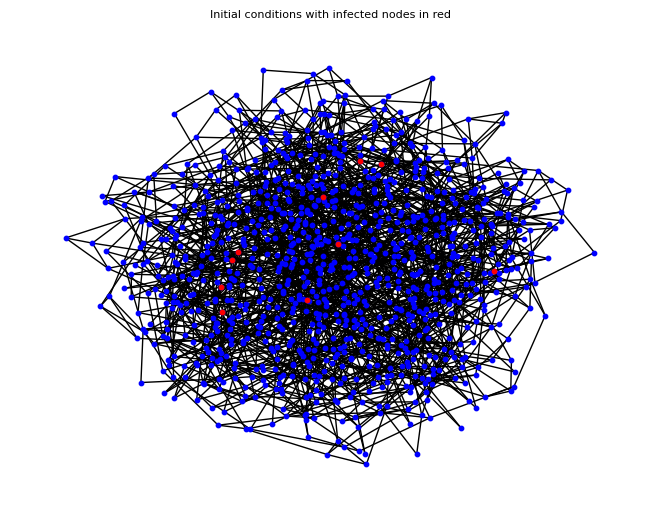

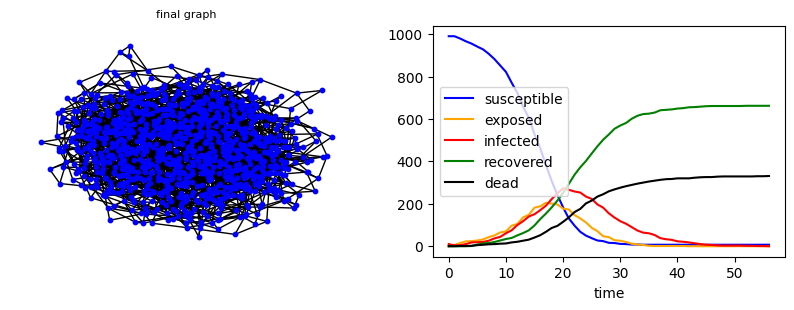

In [17]:
#debug cell

BA=nx.watts_strogatz_graph(1000,5, 0.5, seed=42) 
#BA=nx.barabasi_albert_graph(100, 5)
#BA = nx.configuration_model(nx.random_powerlaw_tree_sequence(500,gamma=2.8 ,tries=100000)); BA.remove_edges_from(nx.selfloop_edges(BA))
#BA=nx.connected_watts_strogatz_graph(1000,8, 0.5, tries=100000)

S,E,I,R,D=[],[],[],[],[]


G_start,S_start,E_start,I_start,R_start,D_start=initialize_SEIRD(BA,I0=10,visualize=True)


S.append(S_start[0]) 
I.append(I_start[0])
R.append(R_start[0])
E.append(E_start[0])
D.append(D_start[0])


                                               #E->I        S->E    I->R      I->D
G_start,t,S,E,I,R,D = SEIRD(G_start,S,E,I,R,D,sigma=1/3 ,beta=1/2,mu=1/7, theta=1/12,simulation_time=1000,info=True)


plot_seird(G_start,S,E,I,R,D)

## Coupling SEIRD and Fear
- first layer SEIRD epidemic on contact network
- second layer Fear spreading on social network


average degree: 5.982
converged in: 447 steps
maximal number of infected nodes: 731 at time step: 21


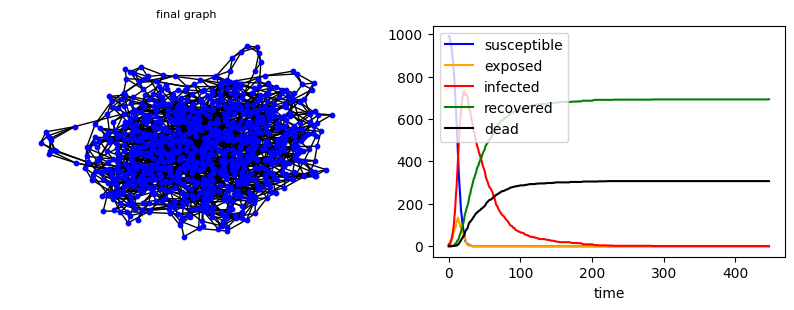

In [2]:
######initialize the fear layer###############

A=nx.barabasi_albert_graph(1000, 3)
#print average degree
deg = np.mean([d for n, d in A.degree()])
print("average degree:", deg)

F=starting_fear(A,mean=0,std=0,visualize=False)

#######initialize the epidemic layer############

BA=nx.watts_strogatz_graph(1000,5, 0.2, seed=42)


S,E,I,R,D=[],[],[],[],[]

G_start,S_start,E_start,I_start,R_start,D_start=initialize_SEIRD(BA,I0=10,visualize=False)

S.append(S_start[0])
I.append(I_start[0])
R.append(R_start[0])
E.append(E_start[0])
D.append(D_start[0])
                                                                #E->I   S->E    I->R   I->D
G_start,t,S,E,I,R,D,fear_t = SEIRD_fear(G_start,F,S,E,I,R,D,sigma=0.6 ,beta=0.7,mu=0.2/10, theta=0.1/10,simulation_time=1000,info=True,a=1,b=1)

plot_seird(G_start,S,E,I,R,D)

plt.show()

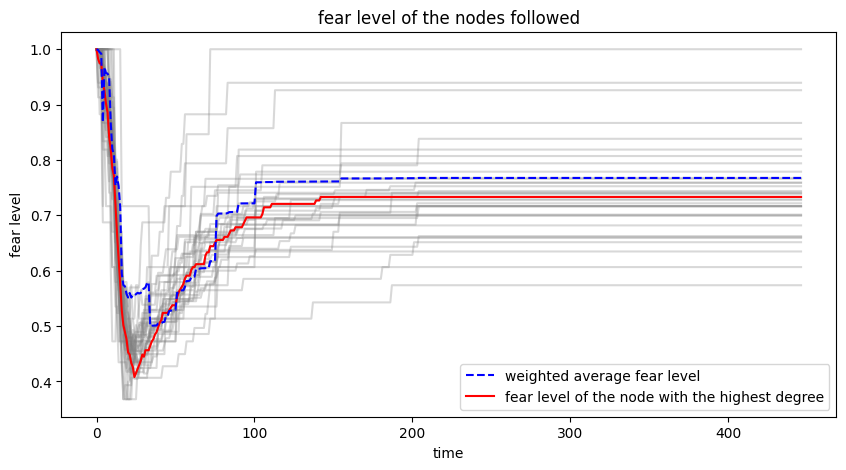

In [4]:
plot_fear(fear_t, F)

average degree of fear net: 43.69101262688784
average degree of epidemic net: 4.0
converged in: 52 steps
maximal number of infected nodes: 273 at time step: 23


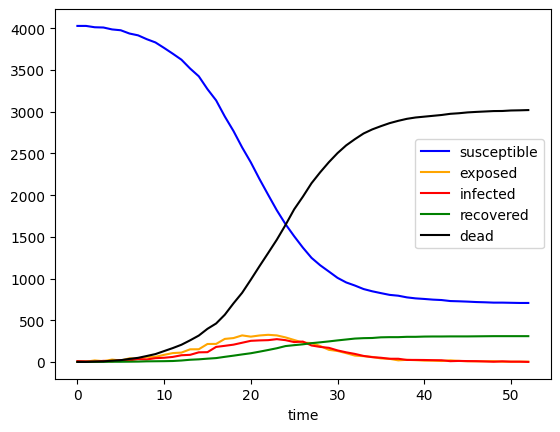

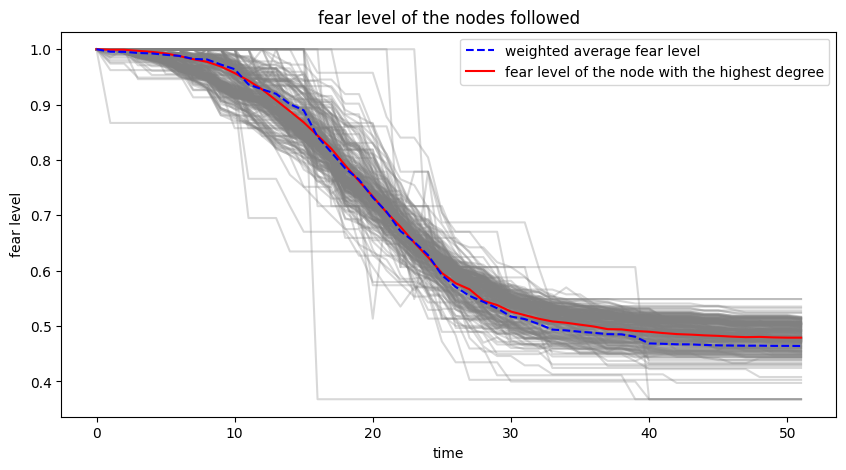

In [5]:
#initialize the fear layer with fb



######initialize the fear layer###############

A = nx.read_edgelist('facebook_combined.txt',nodetype=float)
#A=nx.barabasi_albert_graph(1000, 2)
#number of nodes
N = A.number_of_nodes()
deg = np.mean([d for n, d in A.degree()])
print("average degree of fear net:", deg)

#initialize to 1 = no fear
F = starting_fear(A,mean=1,std=0,visualize=False)

#######initialize the epidemic layer############

BA=nx.watts_strogatz_graph(N,5, 0.2, seed=42)
deg = np.mean([d for n, d in BA.degree()])
print("average degree of epidemic net:", deg)

S,E,I,R,D=[],[],[],[],[]

G_start,S_start,E_start,I_start,R_start,D_start=initialize_SEIRD(BA,I0=10,visualize=False)

S.append(S_start[0])
I.append(I_start[0])
R.append(R_start[0])
E.append(E_start[0])
D.append(D_start[0])
                                                                #E->I   S->E    I->R   I->D
G_start,t,S,E,I,R,D,fear_t = SEIRD_fear(G_start,F,S,E,I,R,D,sigma=0.6 ,beta=0.7,mu=0.2, theta=0.7,simulation_time=1000,info=True,a=1,b=1)

plot_seird(G_start,S,E,I,R,D, graph=False)
plot_fear(fear_t, F)
plt.show()


### Comparison of Standard SEIRD and SEIRD coupled with FEAR

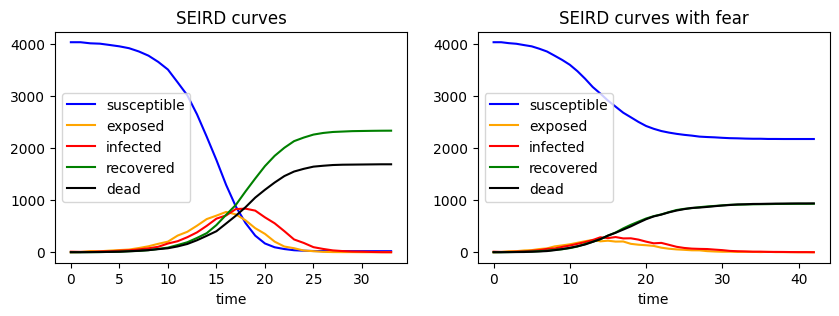

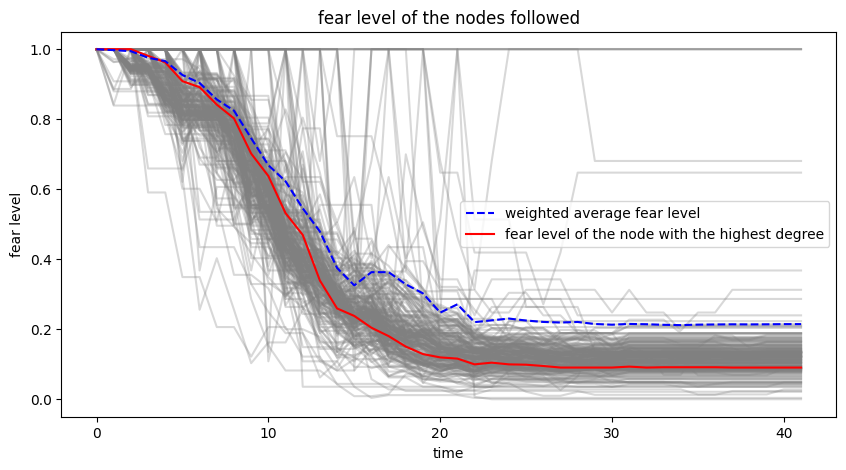

In [6]:
##############choose the fear net#################

#A=nx.barabasi_albert_graph(1000, 2)
A = nx.read_edgelist('facebook_combined.txt',nodetype=float)

N=A.number_of_nodes()

#############choose the epidemic net################

BA=nx.watts_strogatz_graph(N,5, 0.5, seed=42)
 #make a copy of the graph 
#BA=nx.barabasi_albert_graph(N, 5)
#BA = nx.configuration_model(nx.random_powerlaw_tree_sequence(N,gamma=2.8 ,tries=100000)); BA.remove_edges_from(nx.selfloop_edges(BA))
#BA=nx.connected_watts_strogatz_graph(N,8, 0.5, tries=100000)

_,_,I,If,t,tf=compare_fear(A,BA, I0=10, sigma=0.6, beta=0.7, mu=0.3,theta=0.3,sim_time=1000, visualize=True,a=10,b=10)

In [113]:
##############choose the fear net#################

#A=nx.barabasi_albert_graph(1000, 2)
A = nx.read_edgelist('facebook_combined.txt',nodetype=float)

N=A.number_of_nodes()

#############choose the epidemic net################

BA=nx.watts_strogatz_graph(N,5, 0.5, seed=42)
 #make a copy of the graph 
#BA=nx.barabasi_albert_graph(N, 5)
#BA = nx.configuration_model(nx.random_powerlaw_tree_sequence(N,gamma=2.8 ,tries=100000)); BA.remove_edges_from(nx.selfloop_edges(BA))
#BA=nx.connected_watts_strogatz_graph(N,8, 0.5, tries=100000)

#_,_,I,If,t,tf=compare_fear(A,BA, I0=10, sigma=0.6, beta=0.7, mu=0.2,theta=0.1,sim_time=1000, visualize=True,a=10,b=10)


mu=0.5
beta=np.linspace(0.1,0.9,5)
theta=np.linspace(0.1,0.9,5)

R0_stat = np.zeros((len(beta),len(theta)))
R0_adaptive = np.zeros((len(beta),len(theta)))
I_max = np.zeros((len(beta),len(theta)))            #maximal number of infected nodes
I_max_adaptive = np.zeros((len(beta),len(theta)))
t_max_stat = np.zeros((len(beta),len(theta)))       #time of extinction of the epidemic
t_max_adaptive = np.zeros((len(beta),len(theta)))

num_simulations = 2

for i in tqdm(range(len(beta))):
    for j in range(len(theta)):
        R0_stat_sum = 0
        R0_adaptive_sum = 0
        I_max_sum = 0
        I_max_adaptive_sum = 0
        t_stat_sum = 0
        t_adaptive_sum = 0
        
        for _ in range(num_simulations):
            _,_,I,If,t_stat,t_dyn=compare_fear(A,BA, I0=10, sigma=0.6, beta=beta[i], mu=mu,theta=theta[j],sim_time=1000, visualize=False,a=1,b=1)
            R0_stat_sum += fitR0(I, start = 0, mu = mu, log = False, info=False)
            R0_adaptive_sum += fitR0(If, start = 0, mu = mu, log = False, info=False)
            I_max_sum += max(I)
            I_max_adaptive_sum += max(If)
            t_stat_sum += t_stat
            t_adaptive_sum += t_dyn
        
        R0_stat[i,j] = R0_stat_sum / num_simulations
        R0_adaptive[i,j] = R0_adaptive_sum / num_simulations
        I_max[i,j] = I_max_sum / num_simulations
        I_max_adaptive[i,j] = I_max_adaptive_sum / num_simulations
        t_max_stat[i,j] = t_stat_sum / num_simulations
        t_max_adaptive[i,j] = t_adaptive_sum / num_simulations


#save the results to a dataframe for easier visualization
R0_stat = pd.DataFrame(R0_stat, index=np.round(beta,2), columns=np.round(theta,2))
R0_adaptive = pd.DataFrame(R0_adaptive, index=np.round(beta,2), columns=np.round(theta,2))
I_max = pd.DataFrame(I_max, index=np.round(beta,2), columns=np.round(theta,2)) #final attack rate
I_max_adaptive = pd.DataFrame(I_max_adaptive, index=np.round(beta,2), columns=np.round(theta,2))
t_stat = pd.DataFrame(t_max_stat, index=np.round(beta,2), columns=np.round(theta,2)) #time to extinction
t_adaptive = pd.DataFrame(t_max_adaptive, index=np.round(beta,2), columns=np.round(theta,2))


 20%|██        | 1/5 [00:19<01:19, 19.80s/it]

100 2
100 12
100 7
100 13
100 8
100 4


100%|██████████| 5/5 [04:04<00:00, 48.82s/it]


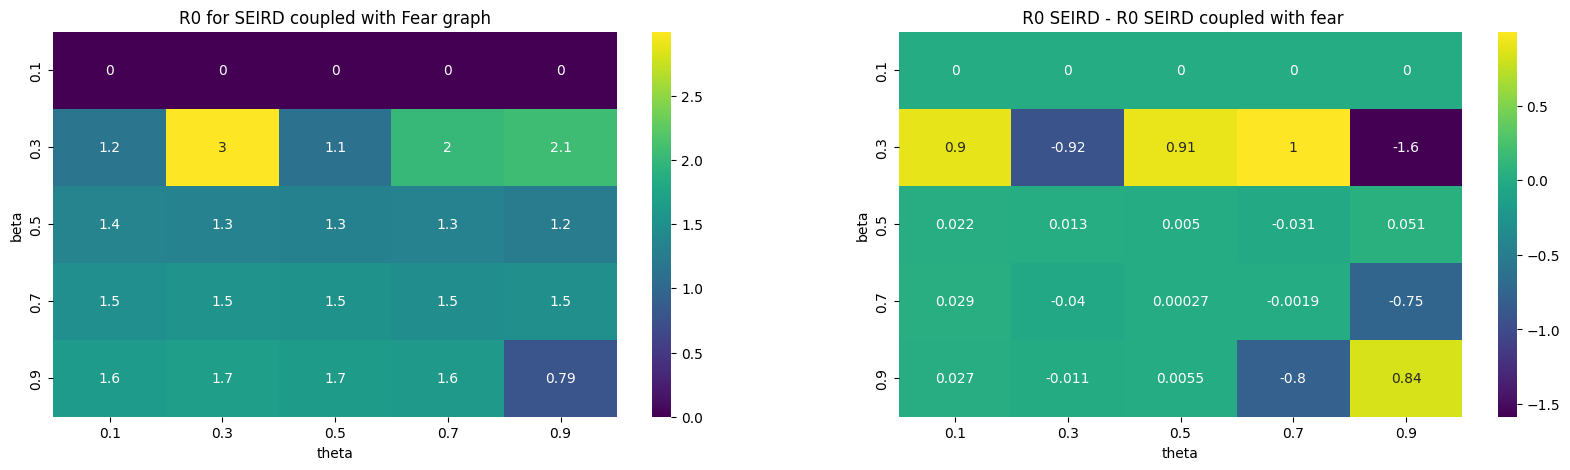

In [116]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(R0_adaptive, annot=True, cmap='viridis')
plt.title('R0 for SEIRD coupled with Fear graph')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)

sns.heatmap(R0_stat-R0_adaptive, annot=True, cmap='viridis')
plt.title(' R0 SEIRD - R0 SEIRD coupled with fear')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/R0_SEIRD.png', dpi=300)
plt.show()

In [ ]:
## R0 similar

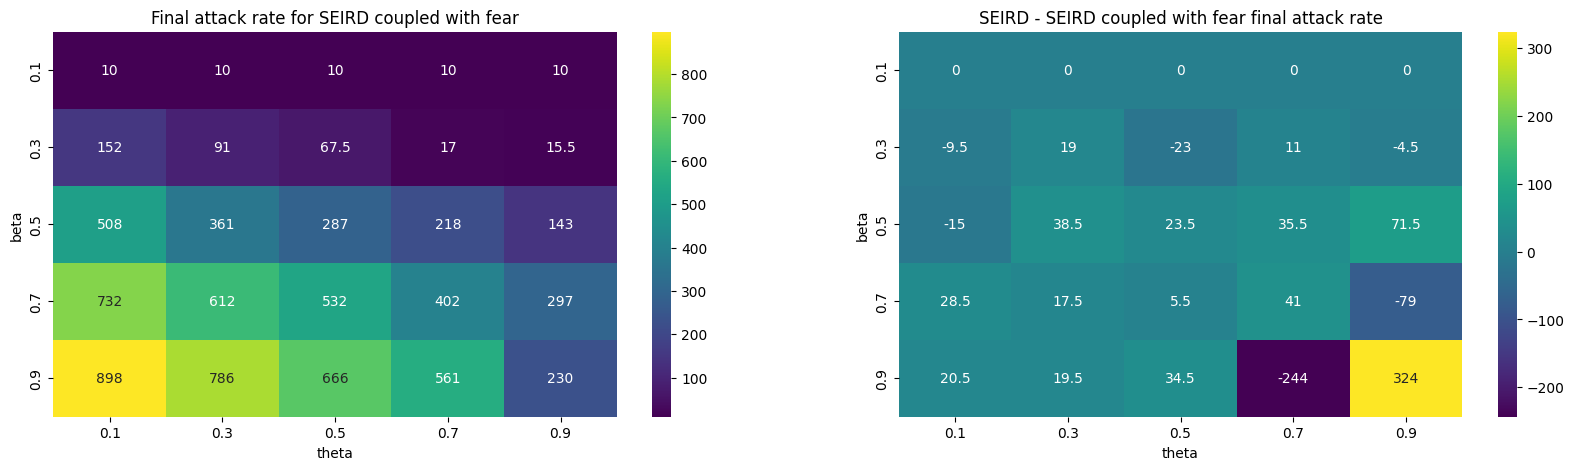

In [118]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(I_max_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('Final attack rate for SEIRD coupled with fear')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)
sns.heatmap(I_max-I_max_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('SEIRD - SEIRD coupled with fear final attack rate')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/attack_rate_SEIRD.png', dpi=300)
plt.show()


In [ ]:
#final attack rate lower for SEIRD coupled with fear

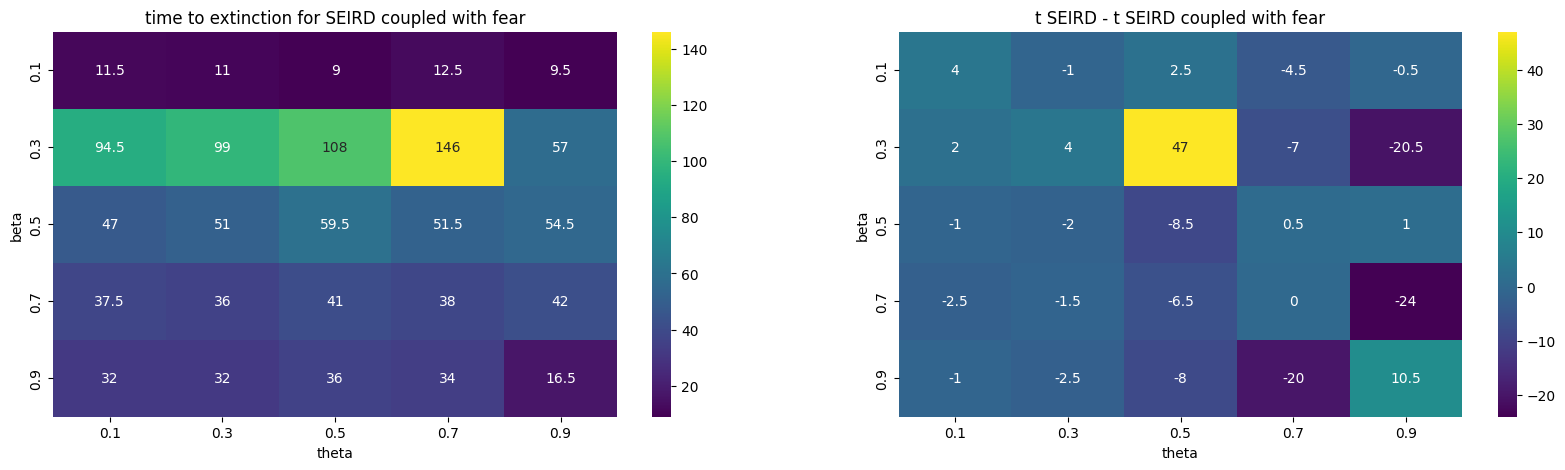

In [121]:

#create two heatmaps for the static and adaptive case and the difference between them
plt.figure(figsize=(20,5))


plt.subplot(1, 2, 1)
sns.heatmap(t_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('time to extinction for SEIRD coupled with fear')
plt.xlabel('theta')
plt.ylabel('beta')

plt.subplot(1, 2, 2)

sns.heatmap(t_stat-t_adaptive, annot=True, cmap='viridis',fmt='.3g')
plt.title('t SEIRD - t SEIRD coupled with fear')
plt.xlabel('theta')
plt.ylabel('beta')

# Display the heatmap
plt.savefig('img/time_to_extinction_SEIRD.png', dpi=300)
plt.show()
